# Weak Supervision (Gaussian Toy Example)

In this notebook, we will demonstrate the basics of weak supervision in the context of anomaly detection. 
We will use simple Gaussian toy data to demonstrate the basic concepts. 
For a similar demonstration on realistic physics data, see the `weak_supervision.ipynb` notebook.

The usual approach to find a powerful discriminant for distinguishing two classes of data (here signal and background) from each other, is to train a machine learning classifier (e.g. a neural network) to distinguish the classes from each other, based on some input features $x$. At each training iteration, we compare the output of the classifier $f(x)$ to the actual label $y$ (1 for signal, 0 for background) of the training data via the loss function (usually binary cross entropy) and optimize the weights of the classifier such that they match as well as possible. What the classifier learns then is to approximate the likelihood ratio $\frac{p_{sig}}{p_{bkg}}$, which is the most powerful test statistic according to the Neyman Pearson Lemma. This *fully supervised classifier* relies on knowing a-priori which training data are signal and which are background during training.

However, there might be cases where one does not have such truth labels in advance. This is often the case in anomaly detection where one searches for small hints of anomalous signal within an overwhelming background, without knowing ahead of time what the signal looks like. In this case we only have our measured data, that consists of background and maybe some signal. We do not know the true 'label' of any of these data events, so we cannot perform traditional supervised training.
In addition, we somehow got an extra sample of just background data. If that was the case, we could just train a classifier to distinguish these two classes (data=sig+bkg vs bkg). Our classifier would approach a likelihood ratio that is monotonically linked to the signal-vs-bkg one $\frac{p_{(sig+bkg)}}{p_{bkg}} = \frac{f_{sig} p_{sig} + (1- f_{sig}) p_{bkg}}{p_{bkg}} = f_{sig} \frac{p_{sig}}{p_{bkg}} + (1 - f_{sig})$ where $f_{sig}$ is the (unknown) signal fraction in the data.
This method of training is called weak supervision. 

A significant challenge in the application of this method is where to get the magic background-only sample. One might have a very good Monte Carlo simulation, or one might instead generate it in-situ via some data-driven estimate. The latter is the approach that multiple weak supervision methods take, such as [CWoLa Hunting](https://arxiv.org/abs/1902.02634), [SALAD](https://arxiv.org/abs/2212.10579), [CATHODE](https://arxiv.org/abs/2109.00546), [CURTAINS](https://arxiv.org/abs/2203.09470), [FETA](https://arxiv.org/abs/2212.11285). For now, we just assume we already have such a large background-only sample. We often refer to this idealization as the *idealized anomaly detector* (IAD).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sys

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from os.path import exists, join, dirname, realpath

# adding parent directory to path
parent_dir = dirname(realpath(globals()["_dh"][0]))
sys.path.append(parent_dir)

from sk_cathode.classifier_models.neural_network_classifier import NeuralNetworkClassifier
from sk_cathode.utils.evaluation_functions import plot_roc_and_sic

In [2]:
# :sunglasses:
plt.style.use('dark_background')

First, lets define the data distributions we will be working with. 
Since we are generating the data ourselves we can pick its dimensionality, and how different the signal and background are.
For now lets keep it simple and work with two dimensional data, but feel free to come back and play around with this choice. 

In [3]:
# Pick the dimensionality of our dataset
n_dim = 2  # How many total dimensions of our data
n_signal_dim = 2  # How many dimensions of our signal are different from background

# Background is multi-dim Gaussian with zero mean, diagonal covariance of one
bkg_means = np.array([0.]*n_dim)
bkg_vars = np.ones(n_dim)
bkg_cov = np.diag(bkg_vars)
bkg_pdf = scipy.stats.multivariate_normal(bkg_means, bkg_cov)

# Signal is multi-dim Gaussian centered at 1 for 'signal like dimensions and 0 for the bkg-like dimensions
sig_means = np.array([1.0] * n_signal_dim + [0.] * (n_dim - n_signal_dim))
sig_vars = np.array(n_signal_dim * [0.1] + [1.0] * (n_dim - n_signal_dim))
sig_cov = np.diag(sig_vars)
sig_pdf = scipy.stats.multivariate_normal(sig_means, sig_cov)

verbose = 0

In [4]:
# Data for training of supervised classifer
n_sup = 5000
sig_events_sup = sig_pdf.rvs(size=n_sup)
bkg_events_sup = bkg_pdf.rvs(size=n_sup)

x_sup = np.append(sig_events_sup, bkg_events_sup, axis=0)
y_sup = np.append(np.ones(n_sup, dtype = np.int8), 
                  np.zeros(n_sup, dtype =np.int8))

x_sup, y_sup = shuffle(x_sup, y_sup, random_state = 42)
x_sup_train, x_sup_val, y_sup_train, y_sup_val = train_test_split(x_sup, y_sup, test_size=0.2, random_state=42)

# Data for testing
n_test = 50000
sig_events_test = sig_pdf.rvs(size=n_test//10)
bkg_events_test = bkg_pdf.rvs(size=n_test)

x_test = np.append(sig_events_test, bkg_events_test, axis=0)
y_test = np.append(np.ones(n_test//10, dtype=np.int8), np.zeros(n_test, dtype=np.int8))

Lets plot our data to get a feel of how the distributions we defined look 

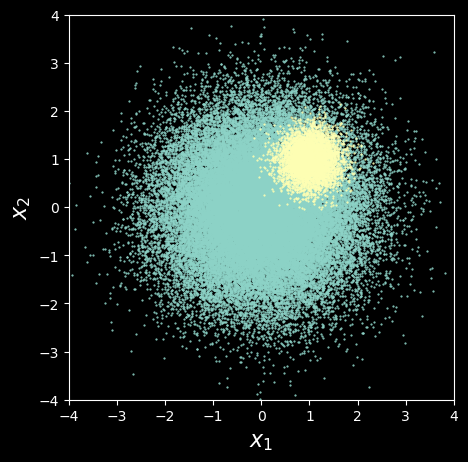

In [5]:
# Simple scatter plot of our data, background is in blue, signal is in orange
plt.figure(figsize = (5, 5))
plt.scatter(bkg_events_test[:,0], bkg_events_test[:,1], s=0.3, color='C0')
plt.scatter(sig_events_test[:,0], sig_events_test[:,1], s=0.3, color='C1')
plt.gca().set_aspect(1.)
plt.xlabel(r'$x_1$', fontsize=16)
plt.ylabel(r'$x_2$', fontsize=16)
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.show()

Note that for this example, the signal is entirely contained within the distribution of the background.
So in this case, our anomaly is an overdensity of events within a particular region of phase space. 
This can easily occur for realistic particle physics examples in which backgrounds (such as QCD) are copious and populate a huge phase space. 
For many other fields, anomalies are always outliers, entirely outside the phase space of typical backgrounds. 
Methods which are built on the idea of finding outliers (eg autoencoders) may therefore struggle to find this type of anomaly. 

In [6]:
# Supervised model
sup_model = NeuralNetworkClassifier(n_inputs=n_dim,
                                    early_stopping=True, epochs=100,
                                    verbose=True)
sup_model.fit(x_sup_train, y_sup_train, x_sup_val, y_sup_val)


Epoch: 0


Train loss: 0.398852: 100%|██████████| 8000/8000 [00:00<00:00, 10100.06it/s]


Validation loss: 0.24452376645058393

Epoch: 1


Train loss: 0.214940: 100%|██████████| 8000/8000 [00:00<00:00, 53687.26it/s]


Validation loss: 0.22847513481974602

Epoch: 2


Train loss: 0.202869: 100%|██████████| 8000/8000 [00:00<00:00, 50746.63it/s]


Validation loss: 0.23143309680745006

Epoch: 3


Train loss: 0.200003: 100%|██████████| 8000/8000 [00:00<00:00, 53567.27it/s]


Validation loss: 0.22677385620772839

Epoch: 4


Train loss: 0.199161: 100%|██████████| 8000/8000 [00:00<00:00, 51323.81it/s]


Validation loss: 0.2229026285931468

Epoch: 5


Train loss: 0.195453: 100%|██████████| 8000/8000 [00:00<00:00, 50717.10it/s]


Validation loss: 0.225134058855474

Epoch: 6


Train loss: 0.194862: 100%|██████████| 8000/8000 [00:00<00:00, 53577.19it/s]


Validation loss: 0.22416507452726364

Epoch: 7


Train loss: 0.193670: 100%|██████████| 8000/8000 [00:00<00:00, 52097.98it/s]


Validation loss: 0.22197876032441854

Epoch: 8


Train loss: 0.194049: 100%|██████████| 8000/8000 [00:00<00:00, 53558.81it/s]


Validation loss: 0.22299362067133188

Epoch: 9


Train loss: 0.193792: 100%|██████████| 8000/8000 [00:00<00:00, 56109.68it/s]


Validation loss: 0.22367635555565357

Epoch: 10


Train loss: 0.193099: 100%|██████████| 8000/8000 [00:00<00:00, 56147.61it/s]


Validation loss: 0.22447406686842442

Epoch: 11


Train loss: 0.196229: 100%|██████████| 8000/8000 [00:00<00:00, 54789.46it/s]


Validation loss: 0.22358484100550413

Epoch: 12


Train loss: 0.194461: 100%|██████████| 8000/8000 [00:00<00:00, 55810.94it/s]


Validation loss: 0.21918935142457485

Epoch: 13


Train loss: 0.192830: 100%|██████████| 8000/8000 [00:00<00:00, 56990.15it/s]


Validation loss: 0.22257069684565067

Epoch: 14


Train loss: 0.193401: 100%|██████████| 8000/8000 [00:00<00:00, 55335.29it/s]


Validation loss: 0.22256567608565092

Epoch: 15


Train loss: 0.193739: 100%|██████████| 8000/8000 [00:00<00:00, 55189.39it/s]


Validation loss: 0.22173771262168884

Epoch: 16


Train loss: 0.193322: 100%|██████████| 8000/8000 [00:00<00:00, 56842.73it/s]


Validation loss: 0.2200046912766993

Epoch: 17


Train loss: 0.192193: 100%|██████████| 8000/8000 [00:00<00:00, 55277.67it/s]


Validation loss: 0.22544025164097548

Epoch: 18


Train loss: 0.192789: 100%|██████████| 8000/8000 [00:00<00:00, 52934.24it/s]


Validation loss: 0.22439221292734146

Epoch: 19


Train loss: 0.193283: 100%|██████████| 8000/8000 [00:00<00:00, 56989.76it/s]


Validation loss: 0.2273670183494687

Epoch: 20


Train loss: 0.191792: 100%|██████████| 8000/8000 [00:00<00:00, 55948.67it/s]


Validation loss: 0.2213165215216577

Epoch: 21


Train loss: 0.192770: 100%|██████████| 8000/8000 [00:00<00:00, 55726.50it/s]


Validation loss: 0.22357016522437334

Epoch: 22


Train loss: 0.192098: 100%|██████████| 8000/8000 [00:00<00:00, 55668.63it/s]


Validation loss: 0.22324914298951626
Early stopping at epoch 22


NeuralNetworkClassifier(early_stopping=True, n_inputs=2, verbose=True)

In [7]:
# Do a quick check of the performance of the supervised classifier 
y_test_sup = sup_model.predict(x_test)
auc_sup = roc_auc_score(y_test, y_test_sup)

print(f"Supervised AUC {auc_sup:.3f}")

Supervised AUC 0.966


Because we know the full probability distributions in this toy example, 
we can compare our supervised classifier to the true likelihood ratio (which is the optimal classifier).


In [8]:
# Use exact likelihood ratio to get optimal performance likelihood ratio
x_test_bkg_pdf = bkg_pdf.pdf(x_test)
x_test_sig_pdf = sig_pdf.pdf(x_test)
likelihood_ratio = x_test_sig_pdf / x_test_bkg_pdf

auc_ratio = roc_auc_score(y_test, likelihood_ratio)
print(f"likelihood ratio AUC {auc_ratio:.3f}")

likelihood ratio AUC 0.966


Now let's train an 'idealized anomaly detector' and see how it compares to our supervised classifier. 
This classifier is trained to distinguish between a 'data' sample which is a mixture of signal and background events, and our pure background sample.
The performance of the weak supervision training depends on both the fraction of signal inside our 'data' sample and also the size of the signal and background like samples. 
Larger signal fractions make it easier for the classifier to pick out the signal events. 
Large samples increase the raw number of signal events and reduce the size of statistical fluctuations of the background events in the 'data' sample versus the pure background sample. 

We will pick two signal fractions to test out and see how the performance changes. 

In [9]:
# Define number of signal events and total number of events in each sample
n_sig = 500
n_sample = 50000
sig_frac1 = n_sig / n_sample

sig_events_anom = sig_pdf.rvs(size=n_sig)
bkg_events_anom = bkg_pdf.rvs(size=2 * n_sample - n_sig)

x_iad = np.append(sig_events_anom, bkg_events_anom, axis=0)
# Labels are all '1' for our data sample (signal + bkg) and '0' for our background-only sample
y_iad = np.append(np.ones(n_sample, dtype=np.int8), np.zeros(n_sample, dtype=np.int8))

x_iad, y_iad = shuffle(x_iad, y_iad, random_state=42)
x_iad_train, x_iad_val, y_iad_train, y_iad_val = train_test_split(x_iad, y_iad, test_size=0.2)

print(f"Training with samples of size {n_sample} and sig frac {sig_frac1:.3f}")


Training with samples of size 50000 and sig frac 0.010


In [10]:
iad_model1 = NeuralNetworkClassifier(n_inputs=n_dim,
                                     early_stopping=True, epochs=100,
                                     verbose=True)
iad_model1.fit(x_iad_train, y_iad_train, x_iad_val, y_iad_val)


Epoch: 0


Train loss: 0.693360: 100%|██████████| 80000/80000 [00:01<00:00, 48989.24it/s]


Validation loss: 0.6933337347522662

Epoch: 1


Train loss: 0.693218: 100%|██████████| 80000/80000 [00:01<00:00, 53548.82it/s]


Validation loss: 0.6931890606120893

Epoch: 2


Train loss: 0.693158: 100%|██████████| 80000/80000 [00:01<00:00, 54853.07it/s]


Validation loss: 0.6936210655862358

Epoch: 3


Train loss: 0.693168: 100%|██████████| 80000/80000 [00:01<00:00, 50730.14it/s]


Validation loss: 0.6932316771738088

Epoch: 4


Train loss: 0.693142: 100%|██████████| 80000/80000 [00:01<00:00, 53622.67it/s]


Validation loss: 0.6931359673001963

Epoch: 5


Train loss: 0.693135: 100%|██████████| 80000/80000 [00:01<00:00, 50362.92it/s]


Validation loss: 0.6931810754879265

Epoch: 6


Train loss: 0.693087: 100%|██████████| 80000/80000 [00:01<00:00, 51358.14it/s]


Validation loss: 0.6931674309596894

Epoch: 7


Train loss: 0.693143: 100%|██████████| 80000/80000 [00:01<00:00, 51589.44it/s]


Validation loss: 0.6932944556710067

Epoch: 8


Train loss: 0.693124: 100%|██████████| 80000/80000 [00:01<00:00, 51286.13it/s]


Validation loss: 0.6931161497049271

Epoch: 9


Train loss: 0.693066: 100%|██████████| 80000/80000 [00:01<00:00, 53376.52it/s]


Validation loss: 0.6933112619029489

Epoch: 10


Train loss: 0.693081: 100%|██████████| 80000/80000 [00:01<00:00, 53310.52it/s]


Validation loss: 0.6933522607870163

Epoch: 11


Train loss: 0.693069: 100%|██████████| 80000/80000 [00:01<00:00, 52088.10it/s]


Validation loss: 0.6931348051994469

Epoch: 12


Train loss: 0.693064: 100%|██████████| 80000/80000 [00:01<00:00, 52716.57it/s]


Validation loss: 0.6931627445919498

Epoch: 13


Train loss: 0.693056: 100%|██████████| 80000/80000 [00:01<00:00, 49372.65it/s]


Validation loss: 0.6931450890887315

Epoch: 14


Train loss: 0.693040: 100%|██████████| 80000/80000 [00:01<00:00, 50107.27it/s]


Validation loss: 0.6931691165942295

Epoch: 15


Train loss: 0.693012: 100%|██████████| 80000/80000 [00:01<00:00, 51400.64it/s]


Validation loss: 0.693171665167353

Epoch: 16


Train loss: 0.693001: 100%|██████████| 80000/80000 [00:01<00:00, 48163.80it/s]


Validation loss: 0.6931631997892052

Epoch: 17


Train loss: 0.693012: 100%|██████████| 80000/80000 [00:01<00:00, 50314.70it/s]


Validation loss: 0.6931829217133249

Epoch: 18


Train loss: 0.693021: 100%|██████████| 80000/80000 [00:01<00:00, 53847.12it/s]


Validation loss: 0.6931299126831589
Early stopping at epoch 18


NeuralNetworkClassifier(early_stopping=True, n_inputs=2, verbose=True)

Notice that the loss value for the weakly supervised does not change much over the course of the training, and is very close to $ln(2) \sim 0.693$.

For the binary cross entropy loss function we are using, $ln(2)$ is the value one would obtain for model that was outputting 0.5 for every input. 
This is a typical feature of weak supervision, and does not necessarily mean the model is performing poorly. Keep in mind that for the vast majority of the training set
the model has the impossible task of trying to distinguish two identical sets of background events, so the best it can do is output 0.5 for all of them.
It is only for signal events, which are only present in one sample, that the model has a hope of identifying the class label. 
So even if the model learns to identify signal well, the loss function will not change much. 

The loss is therefore a poor proxy for performance in weak supervision. 

In [11]:
y_test_iad1 = iad_model1.predict(x_test)
auc_iad1 = roc_auc_score(y_test, y_test_iad1)

print(f"IAD AUC {auc_iad1:.3f}")

IAD AUC 0.928


Now lets try training with a larger signal fraction. 

In [12]:
# Define number of signal events and total number of events in each sample
n_sig2 = 5000
sig_frac2 = n_sig2 / n_sample

sig_events_anom2 = sig_pdf.rvs(size=n_sig2)
bkg_events_anom2 = bkg_pdf.rvs(size=2*n_sample-n_sig2)

x_iad2 = np.append(sig_events_anom2, bkg_events_anom2, axis=0)
# Labels are all '1' for our data sample (signal + bkg) and '0' for our background-only sample
y_iad2 = np.append(np.ones(n_sample, dtype=np.int8), np.zeros(n_sample, dtype =np.int8))

x_iad2, y_iad2 = shuffle(x_iad2, y_iad2, random_state=42)
x_iad_train2, x_iad_val2, y_iad_train2, y_iad_val2 = train_test_split(x_iad2, y_iad2, test_size=0.2)

print(f"Training with samples of size {n_sample} and sig frac {sig_frac2:.3f}")


Training with samples of size 50000 and sig frac 0.100


In [13]:
iad_model2 = NeuralNetworkClassifier(n_inputs=n_dim,
                                     early_stopping=True, epochs=100,
                                     verbose=True)
iad_model2.fit(x_iad_train2, y_iad_train2, x_iad_val2, y_iad_val2)


Epoch: 0


Train loss: 0.687163: 100%|██████████| 80000/80000 [00:01<00:00, 53236.86it/s]


Validation loss: 0.6846085300870762

Epoch: 1


Train loss: 0.684606: 100%|██████████| 80000/80000 [00:01<00:00, 54824.48it/s]


Validation loss: 0.6840041966954614

Epoch: 2


Train loss: 0.684057: 100%|██████████| 80000/80000 [00:01<00:00, 50395.94it/s]


Validation loss: 0.6837394548829194

Epoch: 3


Train loss: 0.683845: 100%|██████████| 80000/80000 [00:01<00:00, 51965.49it/s]


Validation loss: 0.6840399260733537

Epoch: 4


Train loss: 0.683850: 100%|██████████| 80000/80000 [00:01<00:00, 49620.74it/s]


Validation loss: 0.6840958022008277

Epoch: 5


Train loss: 0.683795: 100%|██████████| 80000/80000 [00:01<00:00, 51212.62it/s]


Validation loss: 0.6841116407114989

Epoch: 6


Train loss: 0.683804: 100%|██████████| 80000/80000 [00:01<00:00, 50126.34it/s]


Validation loss: 0.6839998227775477

Epoch: 7


Train loss: 0.683793: 100%|██████████| 80000/80000 [00:01<00:00, 52864.55it/s]


Validation loss: 0.6842011911853864

Epoch: 8


Train loss: 0.683725: 100%|██████████| 80000/80000 [00:01<00:00, 50352.77it/s]


Validation loss: 0.6837627337237072

Epoch: 9


Train loss: 0.683758: 100%|██████████| 80000/80000 [00:01<00:00, 50558.54it/s]


Validation loss: 0.6839687269964035

Epoch: 10


Train loss: 0.683780: 100%|██████████| 80000/80000 [00:01<00:00, 50026.76it/s]


Validation loss: 0.6839666879101164

Epoch: 11


Train loss: 0.683641: 100%|██████████| 80000/80000 [00:01<00:00, 52930.68it/s]


Validation loss: 0.683807143739834

Epoch: 12


Train loss: 0.683734: 100%|██████████| 80000/80000 [00:01<00:00, 53870.67it/s]


Validation loss: 0.683821442400574
Early stopping at epoch 12


NeuralNetworkClassifier(early_stopping=True, n_inputs=2, verbose=True)

In [14]:
y_test_iad2 = iad_model2.predict(x_test)
auc_iad2 = roc_auc_score(y_test, y_test_iad2)

print(f"IAD AUC {auc_iad2:.3f}")

IAD AUC 0.963


Now lets do a proper comparison of the classification performance between this different models. 
We will make a ROC curve which is a common plot of classification performance.
We will also make a 'significance improvement curve' (SIC) which shows much the sensitivity to the signal would be improved but cutting on the score of a given classifier. 

Note that in order to evaluate the performance we need to use the true class labels.

/global/u1/t/train233/2024-lbnl/anomaly_tutorial/sk_cathode/utils/evaluation_functions.py:93: RuntimeWarning: divide by zero encountered in divide
  random_bkg_rej = 1 / random_fpr
/global/u1/t/train233/2024-lbnl/anomaly_tutorial/sk_cathode/utils/evaluation_functions.py:94: RuntimeWarning: invalid value encountered in divide
  random_sic = random_tpr / np.sqrt(random_tpr)


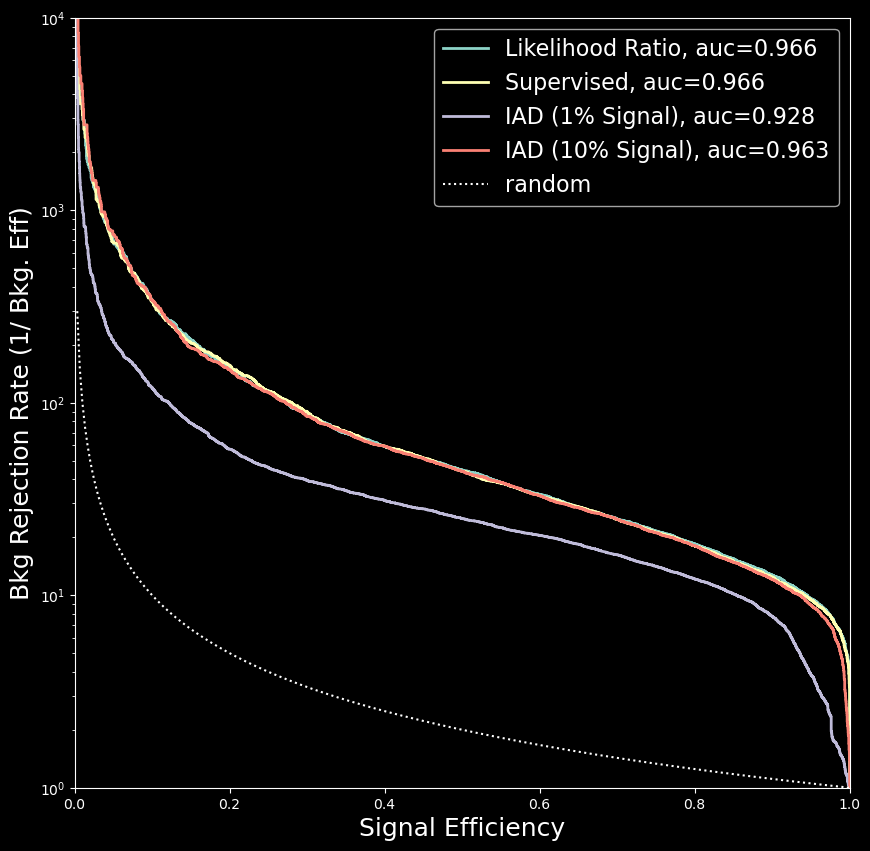

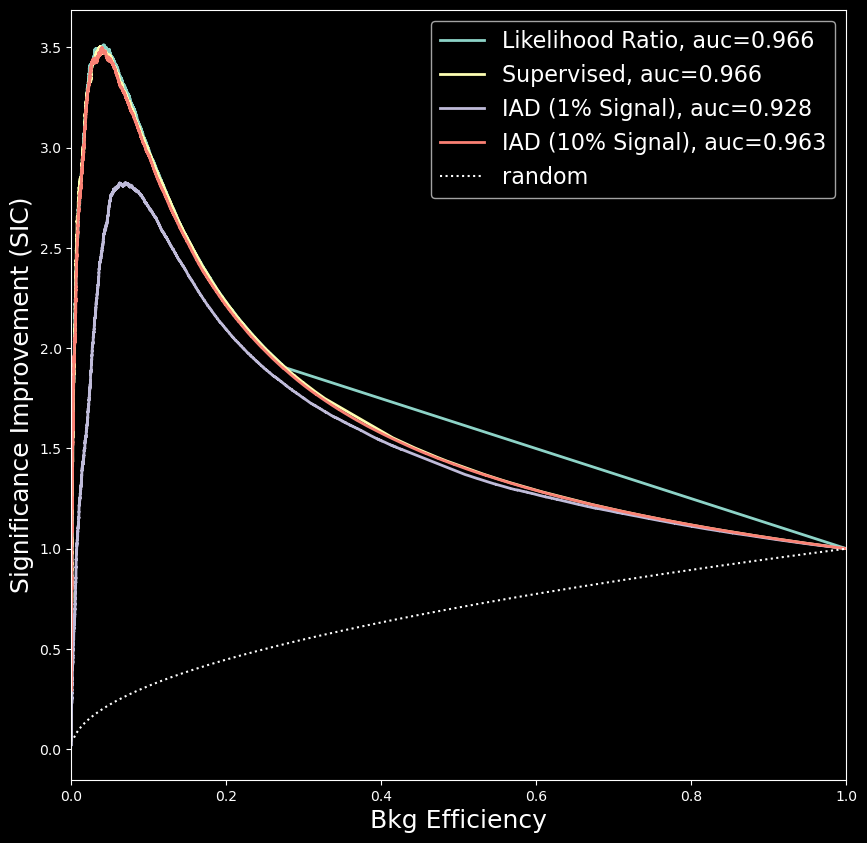

In [18]:
plot_roc_and_sic(y_test,
                 [likelihood_ratio, y_test_sup, y_test_iad1, y_test_iad2],
                 labels=['Likelihood Ratio', 'Supervised', f'IAD ({100.*sig_frac1:.0f}% Signal)', f'IAD ({100.*sig_frac2:.0f}% Signal)'], sic_max = 20)
plt.show()

We can see that the IAD achieves a classification performance equivalent to the supervised classifier for
the 10\% signal case. 
For the 1\% signal case the the performance is not as good, but it is still a pretty good classifier that enhances the sensisitivity by a factor ~3.
This is encouraging because for actual searches on the LHC, 1\% signal fraction is realistic to what one would expect in a realistic scenario.

Feel free to explore how the performance of anomaly detector changes as you play around with the signal fraction, change the distributions of signal and background, and change the dimensionality of the dataset.
